### HW_06 Embedding
> **Обучить сиамскую сеть для верификации лиц на датасете LFW**

In [58]:
import os
import numpy as np


from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.version.VERSION)

2.3.0-dev20200608


In [2]:
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

## Загрузка датасета LFW

In [3]:
ds, ds_info = tfds.load('lfw', 
                        split='train', 
                        shuffle_files=False,
                        as_supervised=True,
                        with_info=True,
                       )

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета 

In [6]:
def show_set(ds):
    fig = plt.figure(figsize=(14, 10))

    for j, example in enumerate(ds.take(24)):
        image, label = example[1],  example[0]
        ax = fig.add_subplot(4, 6, j+1)
        ax.imshow(image)
        label = label.numpy().decode("utf-8")
        ax.set_xlabel(label)
        plt.xticks([]), plt.yticks([])
    plt.show()

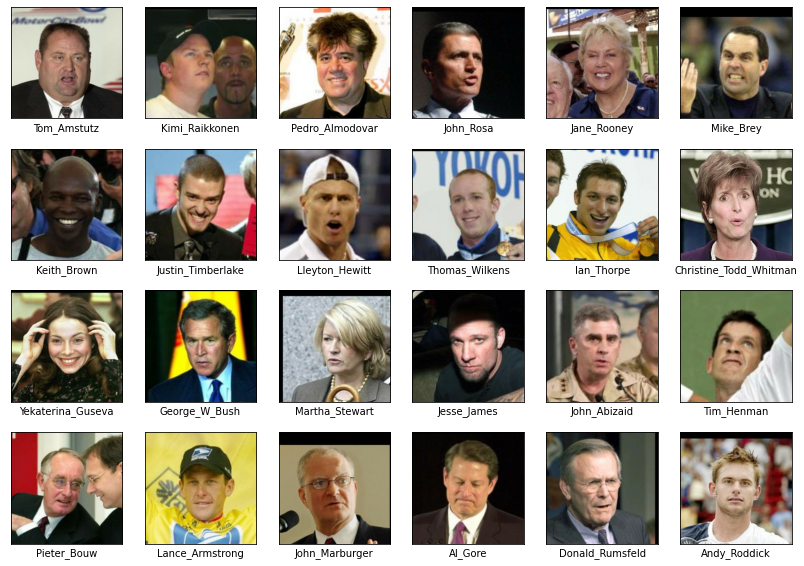

In [7]:
show_set(ds)

## Создание пайплайна данных

In [34]:
NUM_EPOCHS = 10
BATCH_SIZE = 64
INP_SIZE = 250

**преобразуем исходный датасет**

In [9]:
def img_prep(img):
    img = tf.cast(img, tf.float32)/255.
    return img

def prepare(label, img):
    img = img_prep(img)
    return label, img

In [10]:
raw_ds = ds
prep_ds = raw_ds.map(prepare)

**дополнительный отсортированный датасет**

In [57]:
%%time
# получаем set уникальных персон
labels = set()

for item in raw_ds.batch(50).as_numpy_iterator():
    labels|=set(item[0])
    
print(f'Кол-во уникальных персон: {len(labels)}')

Кол-во уникальных персон: 5749
CPU times: user 804 ms, sys: 69.4 ms, total: 873 ms
Wall time: 583 ms


In [14]:
F_NAME=''
def _filter_fn(l, img):
    label = l
    res = (label == tf.convert_to_tensor(F_NAME))
    return res

In [16]:
%%time
sorted_ds = None

for i, label in enumerate(labels):
    F_NAME=label
    f_part = prep_ds.filter(_filter_fn)
#     show_set(f_part)
    
    
    if sorted_ds is None:
        sorted_ds = f_part
    else:
        sorted_ds = sorted_ds.concatenate(f_part)
    
    if i % 500 == 0:
        print(f'i={i}')
#     if i >= 15:
#         break

i=0
i=500
i=1000
i=1500
i=2000
i=2500
i=3000
i=3500
i=4000
i=4500
i=5000
i=5500
CPU times: user 21.6 s, sys: 82.1 ms, total: 21.7 s
Wall time: 21.7 s


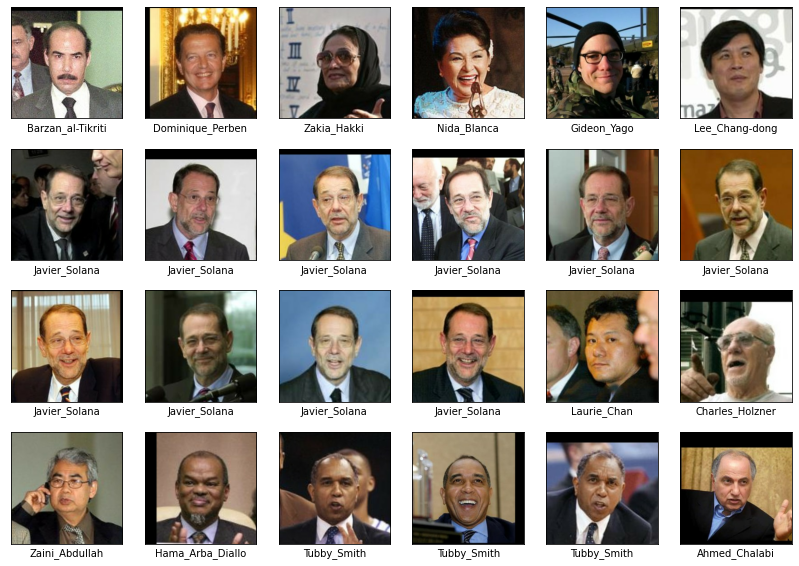

CPU times: user 51min 3s, sys: 8.05 s, total: 51min 11s
Wall time: 50min 38s


In [17]:
%%time
show_set(sorted_ds.take(24))

In [35]:
# объединим датасеты и умножим на кол-во эпох
pred_ds = prep_ds.shuffle(buffer_size=1000)
double_ds = prep_ds.concatenate(sorted_ds)
double_ds = double_ds.repeat(NUM_EPOCHS)

**датасет на основе оконной функции шириной 2**

In [36]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride, drop_remainder=True)

    def sub_to_batch(label, img):
        return tf.data.Dataset.zip((label, img)).batch(window_size, drop_remainder=True)

    windows = windows.flat_map(sub_to_batch)
    return windows


In [37]:
train_ds = make_window_dataset(double_ds, window_size=2, shift = 1, stride=1)

## Создание модели CNN

In [39]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [40]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    loss = tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)
#     if tf.reduce_sum(z)>0:
#         print(labels1.numpy(), labels2.numpy())
#         print(f'd={d}, z={z}, MAX={tf.maximum(0, MARGIN - d)}, loss={loss}')
    return loss

## Подготовка к обучению

In [41]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [30]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [42]:
%%time

for iteration, item in enumerate(train_ds):
    images, labels = item[1], item[0]
   
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 500 == 0:
#         print('[{}] Labels: {}'.format(iteration, labels.numpy()))
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 79.99211883544922
[500] Loss: 0.0
[1000] Loss: 0.0
[1500] Loss: 0.0
[2000] Loss: 0.0
[2500] Loss: 0.0
[3000] Loss: 0.0
[3500] Loss: 0.0
[4000] Loss: 0.0
[4500] Loss: 0.0
[5000] Loss: 0.0
[5500] Loss: 0.0
[6000] Loss: 0.0
[6500] Loss: 0.0
[7000] Loss: 0.0
[7500] Loss: 3.712278127670288
[8000] Loss: 64.87725067138672
[8500] Loss: 0.0
[9000] Loss: 0.0
[9500] Loss: 0.0
[10000] Loss: 0.0
[10500] Loss: 0.0
[11000] Loss: 0.0
[11500] Loss: 0.0
[12000] Loss: 0.0
[12500] Loss: 0.0
[13000] Loss: 0.0
[13500] Loss: 32.30060958862305
[14000] Loss: 3.3786544799804688
[14500] Loss: 3.8857345581054688
[15000] Loss: 4.927309036254883
[15500] Loss: 11.576330184936523
[16000] Loss: 0.3686659336090088
[16500] Loss: 0.7390756011009216
[17000] Loss: 24.600814819335938
[17500] Loss: 5.830533981323242
[18000] Loss: 94.15921020507812
[18500] Loss: 5.927250385284424
[19000] Loss: 2.983762741088867
[19500] Loss: 13.286935806274414
[20000] Loss: 12.817700386047363
[20500] Loss: 3.183227062225342
[21000] 

KeyboardInterrupt: 

In [45]:
tf.get_logger().setLevel(logging.DEBUG)

## Получение эмбеддингов для новых данных

In [46]:
F_NAME='Al_Gore'
f_ds_01 = ds.filter(_filter_fn).shuffle(buffer_size=50).take(2)

In [47]:
# F_NAME='George_W_Bush'
# F_NAME='Yekaterina_Guseva'
F_NAME='Kofi_Annan'

f_ds_02 = ds.filter(_filter_fn).shuffle(buffer_size=50).take(2)

In [48]:
test_ds = f_ds_01.concatenate(f_ds_02).shuffle(buffer_size=10)

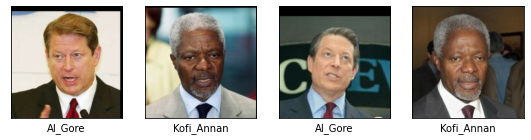

In [49]:
embs = []
fig = plt.figure(figsize=(14, 10))

for j, example in enumerate(test_ds):
    image, label = example[1],  example[0]
           
    img_t = image[tf.newaxis,:]
    embs.append(model(img_t))
        
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(image)
    label = label.numpy().decode("utf-8")
    ax.set_xlabel(label)
    plt.xticks([]), plt.yticks([])
plt.show()

## Вычисление расстояний между эмбеддингами

In [50]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [51]:
def print_diff(embs):
    for i,a in enumerate(embs):
        for j,b in enumerate(embs):
            print(f'A_{i+1} <--> A_{j+1} = {diff(a,b)}')
        print('='*25)

In [52]:
print_diff(embs)

A_1 <--> A_1 = 0.0
A_1 <--> A_2 = 227.30675171450582
A_1 <--> A_3 = 187.40610148818527
A_1 <--> A_4 = 237.53517831576022
A_2 <--> A_1 = 227.30675171450582
A_2 <--> A_2 = 0.0
A_2 <--> A_3 = 204.06473965080298
A_2 <--> A_4 = 143.00437056258104
A_3 <--> A_1 = 187.40610148818527
A_3 <--> A_2 = 204.06473965080298
A_3 <--> A_3 = 0.0
A_3 <--> A_4 = 184.02500679255525
A_4 <--> A_1 = 237.53517831576022
A_4 <--> A_2 = 143.00437056258104
A_4 <--> A_3 = 184.02500679255525
A_4 <--> A_4 = 0.0


## Тестирование на новых данных

In [53]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='constant', anti_aliasing=True)
#     img = (1. - img).astype(np.float32)
#     img = np.mean(img, axis=2)
#     img = np.reshape(img, (250, 250, 1))
    return img

img_a1 = load_and_prepare_image('03_1.jpg')
img_a2 = load_and_prepare_image('01_2.jpg')
img_a3 = load_and_prepare_image('03_3.jpg')
img_a4 = load_and_prepare_image('01_4.jpg')

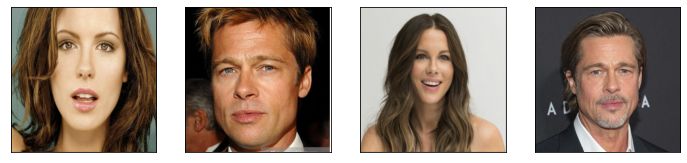

In [54]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_a4)
plt.xticks([]), plt.yticks([])
plt.show()

In [55]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_a4), axis=0))

In [56]:
print_diff(new_embs)

A_1 <--> A_1 = 0.0
A_1 <--> A_2 = 7.532117864852441
A_1 <--> A_3 = 5.730862157380383
A_1 <--> A_4 = 3.6408760737341157
A_2 <--> A_1 = 7.532117864852441
A_2 <--> A_2 = 0.0
A_2 <--> A_3 = 6.8114068790430515
A_2 <--> A_4 = 5.6952793450038035
A_3 <--> A_1 = 5.730862157380383
A_3 <--> A_2 = 6.8114068790430515
A_3 <--> A_3 = 0.0
A_3 <--> A_4 = 4.6203691135275395
A_4 <--> A_1 = 3.6408760737341157
A_4 <--> A_2 = 5.6952793450038035
A_4 <--> A_3 = 4.6203691135275395
A_4 <--> A_4 = 0.0
